# Автоматическая классификация товаров по категориям

Заказчик исследования — платформа для размещения объявлений "Amazon". 

На сайте есть множество объявлений, которые вручную добавляются пользователями. Задача — разработать подход к автоматической классификации объявлений или товаров по категориям, чтобы улучшить процесс модерации и поиска.

**Цель исследования:**

1. Разработка решения по классификации товаров (выбор алгоритма машинного обучения и реализация решения). 
2. Рассмотрение возможных проблем классификации (перекрытие категорий, многоуровневая структура каталога, ошибочные данные).

## 1. Подготовка исходных данных

Загрузка библиотек:

In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
import re
import math
import seaborn as sns

import torch
from transformers import BertTokenizer, BertModel
from tqdm import notebook

from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
RANDOM = 42

In [3]:
pd.set_option("display.max_colwidth", None)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50) 

Возможность расчета на графическом процессоре:

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
path = r"D:/Data_Sciense/amazon_df.csv"
image_path = r"D:/Data_Sciense/images"

if os.path.exists(path):
     df = pd.read_csv(path, index_col=0)
else:
    print('Something is wrong')

In [6]:
df.head()

,name,main_category,sub_category,description,image_name
0,RISARYA H20R1203 IGBT 1PCS POWER TRANSISTOR 20A 1200V REVERSE CONDUCTING HEATING AND WIDELY USED IN INDUCTION COOKER T0247...,appliances,Air Conditioners,"An insulated-gate bipolar transistor (IGBT) is a three-terminal power semiconductor device primarily used as an electronic switch, which, as it was developed, came to combine high efficiency and fast switching",img_0.jpg
1,"Godrej 1 Ton 3 Star Inverter Split AC (GIC 12TTC3-WVA, White)",appliances,Air Conditioners,"Godrej 1 Ton 3 Star Inverter Split AC which assists you with disposing of the warm late spring days by giving prevalent cooling results. It has a 1 Ton limit which settles on it as an optimal decision for a medium-sized room. This climate control system gives ideal cooling in each edge of the room, with an inexact inclusion area of 130 square feet.",img_1.jpg
2,Panasonic 1 Ton 3 Star Wi-Fi Inverter Split Air Conditioner (White),appliances,Air Conditioners,Capacity: 1 Ton - Suitable for small sized rooms (< = 120 sq ft) | Equipped with Powerful and Dry Mode for different cooling needs Energy Star Rating: 3 Star | Annual Power Consumption: 676.37 kWh | ISEER: 3.95. The star rating is as per new BEE guidelines effective from 1st July 2022. Manufacturer Warranty: 1 Year Comprehensive | 5 years on PCB |10 years on Compressor Copper Condenser Coil with Shield Blu Technology: Anti Corrosion Blue Fin Technology | Enhances durability in high humidity coastal areas Special Features: Wi-Fi Air Conditioner | Works with Amazon Alexa and Google Assistant | Voice Control | Smart Diagnosis with One Touch Service | Shield Blu Anti Corrosion Technology | PM 2.5 Filter | Customized Sleep Profiles | Remote Access and Control with Miraie | Stabilizer Free Operation,img_2.jpg
3,Voltas Split Inverter AC 1.5 Ton 3 Star (SAC 183V CZQ),appliances,Air Conditioners,"This model has Turbo Cooling feature and comes with an Eco Friendly Refrigerant. Key Features: Self Diagnosis, High Ambient Cooling, Multi Stage Filtration, Sleep Mode, 100% Copper, Super Silent Operation, Glow Light Buttons on Remote, Dual Temperature Display.",img_3.jpg
4,"Samsung 1.5 Ton 3 Star Convertible 5in1 Inverter Split AC (AR18BY3YAWK, White)",appliances,Air Conditioners,"Convertible 5 in 1 Modes. Cooling Capacity (kW): 5.00. Cooling Capacity (Btu/hr): 17061. Cooling Capacity (Min - Max) (kW): 2.00 - 5.50. Cooling Capacity (Min - Max) (Btu/hr): 6824 - 18767. ISEER (W/W): 3.71. EER (Cooling, Btu/hW): 10.04. Outdoor Noise Level: 53 dB. Power Source Phase: 1. Loading Quantity (20/40/40Hft without Pipe): 92/197/232. Max Piping Length (m): 20. Max Piping Height (m): 12. SVC Valve Liquid (ODxL): 6.35. SVC Valve Gas (ODxL): 12.7. Moisture Removal (l/hr): 2.0. Cooling Air Circulation (Cubic Meter Per Minute): 13.8. Refrigerant (Charging, kg): 0.75. Refrigerant (Charging, tCO2e): 0.51 tCO2e. Low Ambient Cooling (DegreeC): 15 - 52. Outdoor Unit (Anti-corrosion Fin): Yes. Air Flow Control Step (Cool/Fan): 5/4. Filter Cleaning Indicator. Indoor Temp. Display. Display On/Off. Beep On/Off. 24-Hour Timer.",img_4.jpg


**Описание таблицы:**

* <b>name</b> — наименование товара;
* <b>main_category</b> — основная категория (целевой признак);
* <b>sub_category</b> — подкатегория (целевой признак);
* <b>description</b> — текст описания;
* <b>	image_name</b> — ссылка на изображение товара.

К таблице прилагается файл с изображениями товаров. Информация по данным:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16106 entries, 0 to 16105
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           16106 non-null  object
 1   main_category  16106 non-null  object
 2   sub_category   16106 non-null  object
 3   description    3060 non-null   object
 4   image_name     16106 non-null  object
dtypes: object(5)
memory usage: 755.0+ KB


**Промежуточный вывод:**

Исходный датасет имеет 16 106 строк с товарами интернет-магазина Amazon. Каталог имеет двухуровневую структуру (категория и подкатегория товара). Столбец с описанием товаров имеет большое количество пропусков.

## Предобработка

Проверка на дубликаты:

In [8]:
df.duplicated(subset=['name', 'main_category', 'sub_category', 'description']).sum()

145

In [9]:
df = df.drop_duplicates(subset=['name', 'main_category', 'sub_category', 'description'],
                        keep='first')
df.shape

(15961, 5)

Работа с пропусками:

Перед заполнением пропусков стоит добавить к описанию товара текст с его названием для большей информативности, т.к. наименование товара несет в себе его описательные характеристики, пропуски из столбца `description` будут заполнены только наименованием товара.

In [10]:
df['description'] = df['name'] + ' ' + df['description'] 

In [11]:
df.sample(5, random_state=RANDOM)

,name,main_category,sub_category,description,image_name
11992,"Infinizy (Youtuber Choices :13 Years Warranty M5 Smart Band Fitness Watch, Sport Wireless Bluetooth Magnet Headset",sports & fitness,Running,"Infinizy (Youtuber Choices :13 Years Warranty M5 Smart Band Fitness Watch, Sport Wireless Bluetooth Magnet Headset 1.1? Touch color display.5ATM Water Resistant- recognizes swimming mode. Battery runs up to 14 days on a single charge. Battery capacity : 125 mAh It has a sweatproof design and with wireless audio range of 33 ft, you can roam around the house with uncompromised sound quality It is compatible with various brands of Bluetooth phones and Bluetooth notebooks, tablet PCs, MID, etc Weighting only 0.6 oz and coming with interchangeable ear buds and hooks, the headset will stay comfortable on your ears even when you are moving around",img_11992.jpg
14514,"Electronic Spices pack of 10 10K ohm potentiometer, single variable resistor, with power cut switch on/off",industrial supplies,"Test, Measure & Inspect",NaN,img_14514.jpg
10504,Brachy Women's Heavily Soft Double Padded Underwired Push up Bra BCA_TPUPB011,women's clothing,Lingerie & Nightwear,NaN,img_10504.jpg
13540,Kobo Adjustable Weighted Vest PRO Unisex for Fitness Workouts/Training Gym Vest (Imported) (15 Kg),sports & fitness,Strength Training,NaN,img_13540.jpg
11450,THE LITTLE LOOKERS Stainless Steel Insulated Sipper Bottle for Kids/Sipper School Bottle/Sipper Bottle with Straw/Travelli...,toys & baby products,Nursing & Feeding,NaN,img_11450.jpg


Заполнение пропусков названиями товаров:

In [12]:
df['description'] = df['description'].fillna(df['name'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15961 entries, 0 to 16105
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           15961 non-null  object
 1   main_category  15961 non-null  object
 2   sub_category   15961 non-null  object
 3   description    15961 non-null  object
 4   image_name     15961 non-null  object
dtypes: object(5)
memory usage: 748.2+ KB


In [13]:
df.sample(5, random_state=RANDOM)

,name,main_category,sub_category,description,image_name
11992,"Infinizy (Youtuber Choices :13 Years Warranty M5 Smart Band Fitness Watch, Sport Wireless Bluetooth Magnet Headset",sports & fitness,Running,"Infinizy (Youtuber Choices :13 Years Warranty M5 Smart Band Fitness Watch, Sport Wireless Bluetooth Magnet Headset 1.1? Touch color display.5ATM Water Resistant- recognizes swimming mode. Battery runs up to 14 days on a single charge. Battery capacity : 125 mAh It has a sweatproof design and with wireless audio range of 33 ft, you can roam around the house with uncompromised sound quality It is compatible with various brands of Bluetooth phones and Bluetooth notebooks, tablet PCs, MID, etc Weighting only 0.6 oz and coming with interchangeable ear buds and hooks, the headset will stay comfortable on your ears even when you are moving around",img_11992.jpg
14514,"Electronic Spices pack of 10 10K ohm potentiometer, single variable resistor, with power cut switch on/off",industrial supplies,"Test, Measure & Inspect","Electronic Spices pack of 10 10K ohm potentiometer, single variable resistor, with power cut switch on/off",img_14514.jpg
10504,Brachy Women's Heavily Soft Double Padded Underwired Push up Bra BCA_TPUPB011,women's clothing,Lingerie & Nightwear,Brachy Women's Heavily Soft Double Padded Underwired Push up Bra BCA_TPUPB011,img_10504.jpg
13540,Kobo Adjustable Weighted Vest PRO Unisex for Fitness Workouts/Training Gym Vest (Imported) (15 Kg),sports & fitness,Strength Training,Kobo Adjustable Weighted Vest PRO Unisex for Fitness Workouts/Training Gym Vest (Imported) (15 Kg),img_13540.jpg
11450,THE LITTLE LOOKERS Stainless Steel Insulated Sipper Bottle for Kids/Sipper School Bottle/Sipper Bottle with Straw/Travelli...,toys & baby products,Nursing & Feeding,THE LITTLE LOOKERS Stainless Steel Insulated Sipper Bottle for Kids/Sipper School Bottle/Sipper Bottle with Straw/Travelli...,img_11450.jpg


Уникальыне значения `image_name`, должно быть 15961 сколько и товаров:

In [14]:
df['image_name'].nunique()

15961

Все верно, именно столько уникальных товаров содержится в наборе. После заполнения описаний стоит проверить этот факт еще раз:

In [15]:
df.duplicated(subset=['name', 'main_category', 'sub_category', 'description']).sum()

0

**Промежуточный вывод:**

- Обнаружено и удалено 145 явных дубликатов;
- Столбец с описанием дополнен текстом из названия товара, пропущенные значения заполнены.

## Исследование

Разнообразие товарных категорий:

In [16]:
df.pivot_table(index=['main_category', 'sub_category'], values='image_name', aggfunc='count')

image_name
main_category           sub_category                                        
accessories             Bags & Luggage                                   150
                        Fashion & Silver Jewellery                       150
                        Gold & Diamond Jewellery                         132
                        Handbags & Clutches                              149
                        Jewellery                                        150
                        Sunglasses                                       144
                        Watches                                          150
appliances              Air Conditioners                                 150
                        All Appliances                                   150
                        Heating & Cooling Appliances                     150
                        Kitchen & Home Appliances                        150
                        Refrigerators                                    150
                        Washing Machines                                 149
bags & luggage          Backpacks                                        138
                        Rucksacks                                        148
                        Suitcases & Trolley Bags                         150
                        Travel Accessories                               150
                        Travel Duffles                                   148
                        Wallets                                          150
beauty & health         Beauty & Grooming                                150
                        Diet & Nutrition                                 150
                        Health & Personal Care                           150
                        Household Supplies                               149
                        Luxury Beauty                                    149
                        Make-up                                          150
                        Personal Care Appliances                         150
                        Value Bazaar                                      66
car & motorbike         All Car & Motorbike Products                     150
                        Car & Bike Care                                  149
                        Car Accessories                                  150
                        Car Electronics                                  150
                        Car Parts                                        150
                        Motorbike Accessories & Parts                    150
grocery & gourmet foods All Grocery & Gourmet Foods                      150
                        Coffee, Tea & Beverages                          150
                        Snack Foods                                      150
home & kitchen          All Home & Kitchen                               150
                        Bedroom Linen                                    150
                        Furniture                                        150
                        Garden & Outdoors                                150
                        Home Décor                                       150
                        Home Furnishing                                  150
                        Home Improvement                                 148
                        Home Storage                                     149
                        Indoor Lighting                                  150
                        Kitchen & Dining                                 150
                        Kitchen Storage & Containers                     150
                        Sewing & Craft Supplies                          149
industrial supplies     Industrial & Scientific Supplies                 150
                        Janitorial & Sanitation Supplies                 150
                        Lab & Scientific                      

Только для категории `music` найдена всего одна подкатегория.

Количество категорий:

In [17]:
df['main_category'].nunique()

19

Количество подкатегорий:

In [18]:
df['sub_category'].nunique()

111

Гистограмма основных категорий:

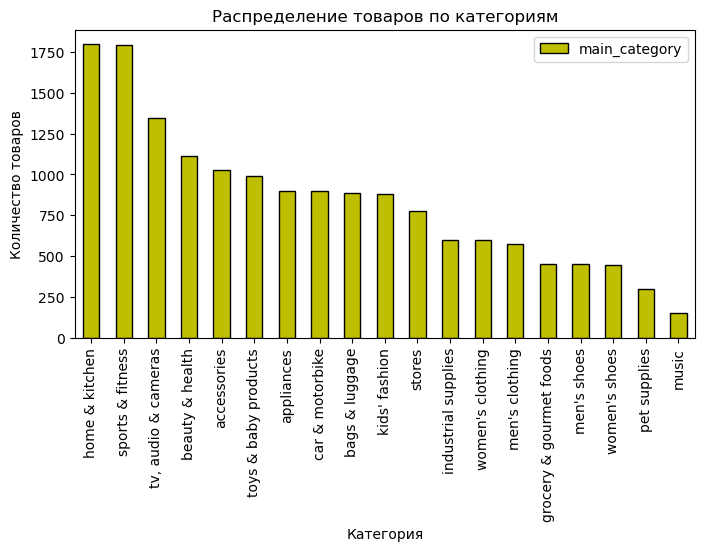

In [19]:
plt.figure(figsize=(8,4))
df['main_category'].value_counts().plot(kind='bar',label='main_category', color='y', ec='black')
plt.legend()
plt.title('Распределение товаров по категориям');
plt.xlabel('Категория');
plt.ylabel('Количество товаров');

1. Категории `tv, audio & cameras` и `appliances` могут пересекаться.
2. В `sports & fitness` могут войти товары из:
    * `men's clothing`,
    * `men's shoes`,
    * `women's clothing`,
    * `women's shoes`.

3. Между `accessories` и `bags & luggage`; `toys & baby products` и `kids' fashion` также могут быть перекрытия.
4. В категорию `stores` может войти все что угодно.

Сводная таблица по категориям `tv, audio & cameras` и `appliances`:

In [20]:
df[(df['main_category'] == 'tv, audio & cameras')|(df['main_category'] == 'appliances')].pivot_table(index=['main_category', 'sub_category'], 
                                                                                                    values='image_name', aggfunc='count')

image_name
main_category       sub_category                            
appliances          Air Conditioners                     150
                    All Appliances                       150
                    Heating & Cooling Appliances         150
                    Kitchen & Home Appliances            150
                    Refrigerators                        150
                    Washing Machines                     149
tv, audio & cameras All Electronics                      150
                    Camera Accessories                   149
                    Cameras                              150
                    Headphones                           150
                    Home Audio & Theater                 150
                    Home Entertainment Systems           150
                    Security Cameras                     149
                    Speakers                             148
                    Televisions                          148

Пересечений не найдено, однако стоит проверить категории `appliances` и `home & kitchen`:

In [21]:
df[(df['main_category'] == 'home & kitchen')|(df['main_category'] == 'appliances')].pivot_table(index=['main_category', 'sub_category'], 
                                                                                                    values='image_name', aggfunc='count')

image_name
main_category  sub_category                            
appliances     Air Conditioners                     150
               All Appliances                       150
               Heating & Cooling Appliances         150
               Kitchen & Home Appliances            150
               Refrigerators                        150
               Washing Machines                     149
home & kitchen All Home & Kitchen                   150
               Bedroom Linen                        150
               Furniture                            150
               Garden & Outdoors                    150
               Home Décor                           150
               Home Furnishing                      150
               Home Improvement                     148
               Home Storage                         149
               Indoor Lighting                      150
               Kitchen & Dining                     150
               Kitchen Storage & Containers         150
               Sewing & Craft Supplies              149

Категория `home & kitchen` не имеет отношения к бытовой технике `appliances`, однако в категории `appliances` имеется подкатегория `Kitchen & Home Appliances`. Эта подкатегория также может относится и к категории `home & kitchen`.

Подкатегории для `accessories` и `bags & luggage`:

In [22]:
df[(df['main_category'] == 'accessories')|(df['main_category'] == 'bags & luggage')].pivot_table(index=['main_category', 'sub_category'], 
                                                                                                    values='image_name', aggfunc='count')

image_name
main_category  sub_category                          
accessories    Bags & Luggage                     150
               Fashion & Silver Jewellery         150
               Gold & Diamond Jewellery           132
               Handbags & Clutches                149
               Jewellery                          150
               Sunglasses                         144
               Watches                            150
bags & luggage Backpacks                          138
               Rucksacks                          148
               Suitcases & Trolley Bags           150
               Travel Accessories                 150
               Travel Duffles                     148
               Wallets                            150

Очень схожие категории. В `accessories` имеется подкатегория `Bags & Luggage`, то же название имеет категория `bags & luggage`.

Примеры изображений товаров:

In [23]:
idx = np.random.choice(len(df['image_name']), 10, replace=False)

image_files = df.iloc[idx]['image_name'].values
category_files = df.iloc[idx]['main_category'].values

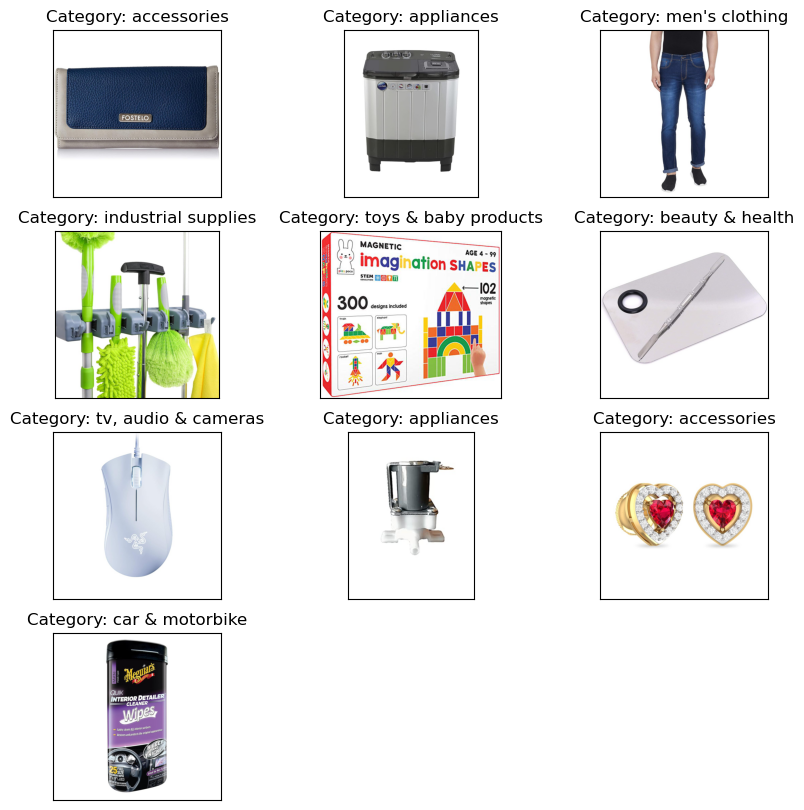

In [24]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(4, 3, i+1)
    image = Image.open(Path(image_path, image_files[i])) 
    plt.imshow(image)
    plt.title(f"Category: {category_files[i]}")
    plt.xticks([])
    plt.yticks([])

Два товара с наручными часами находятся в разных категориях. Блендер можно отнести к категории бытовой техники, однако ему присвоена категория магазины `stores`. Также имеются два товара спортивных трико в разных категориях.

Изображения цветные, разных размеров.

**Промежуточный вывод:**

В датасете имеются товары 19 категорий и 111 подкатегорий. Наиболее общирно представлены категории `home & kitchen` и `sports & fitness`. Наблюдается пересечение категорий и подкатегорий каталога. Товар одного предназначения может быть отнесен в разные категории.

## Возможные проблемы классификации

### Перекрытие категорий

**Возможные последствия:** Присвоив товару только одну категорию, пользователь рискует не увидеть данное предложение в другой ветке каталога, куда этот товар также можно отнести.

**Наличие в наборе данных:** Эта особенность уже наблюдается в текущем наборе данных. Один и тот же товар может быть занесен как в одну, так и в другую категорию, при этом категория будет совершенно обоснованна. Товары могут нести в себе несколько назначений, в зависимости от этого пользователь онлайн-магазина ищет по каталогу ту или иную вещь.

**Решение:** Назначение нескольких категорий для товара. Так пользователь вне зависимости от назначения искомого товара получит возможность увидеть данный товар.

### Многоуровневая структура каталога

**Возможные последствия:** Необходимость классификации товара несколько раз, следовательно применение нескольких моделей классификации, выше риск неверной категоризации.

**Наличие в наборе данных:** Имеется двухуровневый каталог. Только для одной категории имеется всего одна подкатегория. 

**Решение:** Так как подкатегории уникальны и не повторяются между категориями, стоит обучать модель как раз на подкатегории товаров. Если подкатегории не уникальны, стоит назначать таким товарам несколько категорий.

### Ошибочные данные, внесенные пользователем

**Возможные последствия:** Введение модели предсказания в заблуждение, в результате неправильное предсказание категории.

**Наличие в наборе данных:** Не было обнаружено.

**Решение:** Стоит убирать наименее представленные категории и подкатегории (например, менее 10 товаров). Для описаний удалять тексты менее 10 символов или другое число. Для изображений введение анализирующих моделей, которые сопоставят эмбединги изображения и текста.

## Подготовка текста и изображений

### Векторизация текстов

Перед векторизацией стоит очистить текст от спец символов:

In [25]:
def clean_special_chars(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z.,()0-9 ]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [26]:
df['clear_description'] = df['description'].apply(clean_special_chars).str.lower()

In [27]:
df.head()

,name,main_category,sub_category,description,image_name,clear_description
0,RISARYA H20R1203 IGBT 1PCS POWER TRANSISTOR 20A 1200V REVERSE CONDUCTING HEATING AND WIDELY USED IN INDUCTION COOKER T0247...,appliances,Air Conditioners,"RISARYA H20R1203 IGBT 1PCS POWER TRANSISTOR 20A 1200V REVERSE CONDUCTING HEATING AND WIDELY USED IN INDUCTION COOKER T0247... An insulated-gate bipolar transistor (IGBT) is a three-terminal power semiconductor device primarily used as an electronic switch, which, as it was developed, came to combine high efficiency and fast switching",img_0.jpg,"risarya h20r1203 igbt 1pcs power transistor 20a 1200v reverse conducting heating and widely used in induction cooker t0247... an insulated gate bipolar transistor (igbt) is a three terminal power semiconductor device primarily used as an electronic switch, which, as it was developed, came to combine high efficiency and fast switching"
1,"Godrej 1 Ton 3 Star Inverter Split AC (GIC 12TTC3-WVA, White)",appliances,Air Conditioners,"Godrej 1 Ton 3 Star Inverter Split AC (GIC 12TTC3-WVA, White) Godrej 1 Ton 3 Star Inverter Split AC which assists you with disposing of the warm late spring days by giving prevalent cooling results. It has a 1 Ton limit which settles on it as an optimal decision for a medium-sized room. This climate control system gives ideal cooling in each edge of the room, with an inexact inclusion area of 130 square feet.",img_1.jpg,"godrej 1 ton 3 star inverter split ac (gic 12ttc3 wva, white) godrej 1 ton 3 star inverter split ac which assists you with disposing of the warm late spring days by giving prevalent cooling results. it has a 1 ton limit which settles on it as an optimal decision for a medium sized room. this climate control system gives ideal cooling in each edge of the room, with an inexact inclusion area of 130 square feet."
2,Panasonic 1 Ton 3 Star Wi-Fi Inverter Split Air Conditioner (White),appliances,Air Conditioners,Panasonic 1 Ton 3 Star Wi-Fi Inverter Split Air Conditioner (White) Capacity: 1 Ton - Suitable for small sized rooms (< = 120 sq ft) | Equipped with Powerful and Dry Mode for different cooling needs Energy Star Rating: 3 Star | Annual Power Consumption: 676.37 kWh | ISEER: 3.95. The star rating is as per new BEE guidelines effective from 1st July 2022. Manufacturer Warranty: 1 Year Comprehensive | 5 years on PCB |10 years on Compressor Copper Condenser Coil with Shield Blu Technology: Anti Corrosion Blue Fin Technology | Enhances durability in high humidity coastal areas Special Features: Wi-Fi Air Conditioner | Works with Amazon Alexa and Google Assistant | Voice Control | Smart Diagnosis with One Touch Service | Shield Blu Anti Corrosion Technology | PM 2.5 Filter | Customized Sleep Profiles | Remote Access and Control with Miraie | Stabilizer Free Operation,img_2.jpg,panasonic 1 ton 3 star wi fi inverter split air conditioner (white) capacity 1 ton suitable for small sized rooms ( 120 sq ft) equipped with powerful and dry mode for different cooling needs energy star rating 3 star annual power consumption 676.37 kwh iseer 3.95. the star rating is as per new bee guidelines effective from 1st july 2022. manufacturer warranty 1 year comprehensive 5 years on pcb 10 years on compressor copper condenser coil with shield blu technology anti corrosion blue fin technology enhances durability in high humidity coastal areas special features wi fi air conditioner works with amazon alexa and google assistant voice control smart diagnosis with one touch service shield blu anti corrosion technology pm 2.5 filter customized sleep profiles remote access and control with miraie stabilizer free operation
3,Voltas Split Inverter AC 1.5 Ton 3 Star (SAC 183V CZQ),appliances,Air Conditioners,"Voltas Split Inverter AC 1.5 Ton 3 Star (SAC 183V CZQ) This model has Turbo Cooling feature and comes with an Eco Friendly Refrigerant. Key Features: Self Diagnosis, High Ambient Cooling, Multi Stage Filtration, Sleep Mode, 100% Copper, Super Silent

Для векторизации будут применены предобученный токенизатор и модель BERT:

In [28]:
class BertVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model_name='bert-base-uncased', max_length=512, batch_size=64, device='cuda'):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = None
        self.bert = None

    def fit(self, X, y=None):
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert = BertModel.from_pretrained(self.model_name).to(self.device)
        self.bert.eval()
        return self

    def transform(self, X):
        self.bert.eval()
        tokenized = X.apply(lambda x: self.tokenizer.encode(x, 
                                                           max_length=self.max_length,
                                                           add_special_tokens=True,
                                                           truncation=True))
        max_len = max(len(t) for t in tokenized)
        padded = np.array([t + [0]*(max_len-len(t)) for t in tokenized])
        mask = np.where(padded != 0, 1, 0)

        embeddings = []
        for i in range( math.ceil(padded.shape[0] / self.batch_size)):
            input_ids = torch.LongTensor(padded[self.batch_size*i:self.batch_size*(i+1)]).to(self.device)
            attention_mask = torch.LongTensor(mask[self.batch_size*i:self.batch_size*(i+1)]).to(self.device)
            with torch.no_grad():
                outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
                cls_emb = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_emb.cpu().numpy())
        return np.concatenate(embeddings, axis=0)

### Векторизация изображений

Для векторизации изображений будет применена архитектура сверточной нейронной сети ResNet50:

Функция загрузки изображений:

In [29]:
class ImageVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 image_path, 
                 target_size=(224, 224), 
                 batch_size=16,
                 pooling='avg'):
        self.image_path = Path(image_path)
        self.target_size = target_size
        self.batch_size = batch_size
        self.pooling = pooling
        self.model = None

    def _create_model(self):
        model = Sequential()
        model.add(ResNet50(input_shape=(*self.target_size, 3),
                            weights='imagenet',
                            include_top=False))
        model.add(GlobalAveragePooling2D())
        return model

    def fit(self, X, y=None):
        self.model = self._create_model()
        return self

    def transform(self, X):
        df_flow = pd.DataFrame({'image_name': X})
        
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        flow = datagen.flow_from_dataframe(
            dataframe=df_flow,
            directory=self.image_path,
            x_col='image_name',
            y_col=None,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode=None,
            shuffle=False
        )

        features = self.model.predict(flow, verbose=0)
        return features


## Обучение модели на тексте

Разделение на обучающую и тестовую выборки: 

In [30]:
train, test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['sub_category'],
    random_state=RANDOM)

print("Train size:", train.shape, "Test size:", test.shape)

Train size: (12768, 6) Test size: (3193, 6)


Кодирование целевых признаков:

In [31]:
encoder = LabelEncoder()

y_train_main = encoder.fit_transform(train['main_category'])
y_test_main = encoder.transform(test['main_category'])

Тектовая векторизация:

In [32]:
vectorizer = BertVectorizer(batch_size=32, device="cuda")

X_train_text = vectorizer.fit_transform(train['clear_description'])
X_test_text = vectorizer.transform(test['clear_description'])

C:\Users\Diadaro\anaconda3\envs\dissert\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exa

Инициализация модели в пайплайне:

In [33]:
pipe = Pipeline([
    ('clf', LGBMClassifier(random_state=RANDOM))
])

In [34]:
param_grid_1 = [
    {
    'clf': [LogisticRegression(solver="liblinear")],
    'clf__max_iter': [500, 1000],
    'clf__C': [0.1, 1, 5, 10],
    'clf__penalty': ['l1', 'l2']
    },
    {
    'clf': [LinearSVC(random_state=RANDOM, dual=False)],
    'clf__max_iter': [2000, 5000],
    'clf__C': [0.1, 0.5, 1, 5, 10]
    },
    {
        'clf': [RidgeClassifier()],
        'clf__alpha': [0.5, 1.0, 2.0]
    }
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM)

Обучение с перебором гиперпараметров:

In [35]:
grid = GridSearchCV( estimator=pipe,
                    param_grid=param_grid_1, 
                    scoring="f1_macro", 
                    cv=cv,
                    n_jobs=-1)

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_main)

grid.fit(X_train_text, y_train_main, clf__sample_weight=sample_weights)

best_model = grid.best_estimator_

print("Лучшие параметры:", grid.best_params_)
print("Лучший f1_macro:", grid.best_score_)

Лучшие параметры: {'clf': LogisticRegression(solver='liblinear'), 'clf__C': 1, 'clf__max_iter': 500, 'clf__penalty': 'l2'}
Лучший f1_macro: 0.6675535900492


Проверка на тестовой выборке:

In [36]:
y_pred_train_main = best_model.predict(X_train_text)
y_pred_test_main = best_model.predict(X_test_text)

print('Метрика f1-macro на тесте:', f1_score(y_test_main, y_pred_test_main, average='macro'))

Метрика f1-macro на тесте: 0.6702224523946575


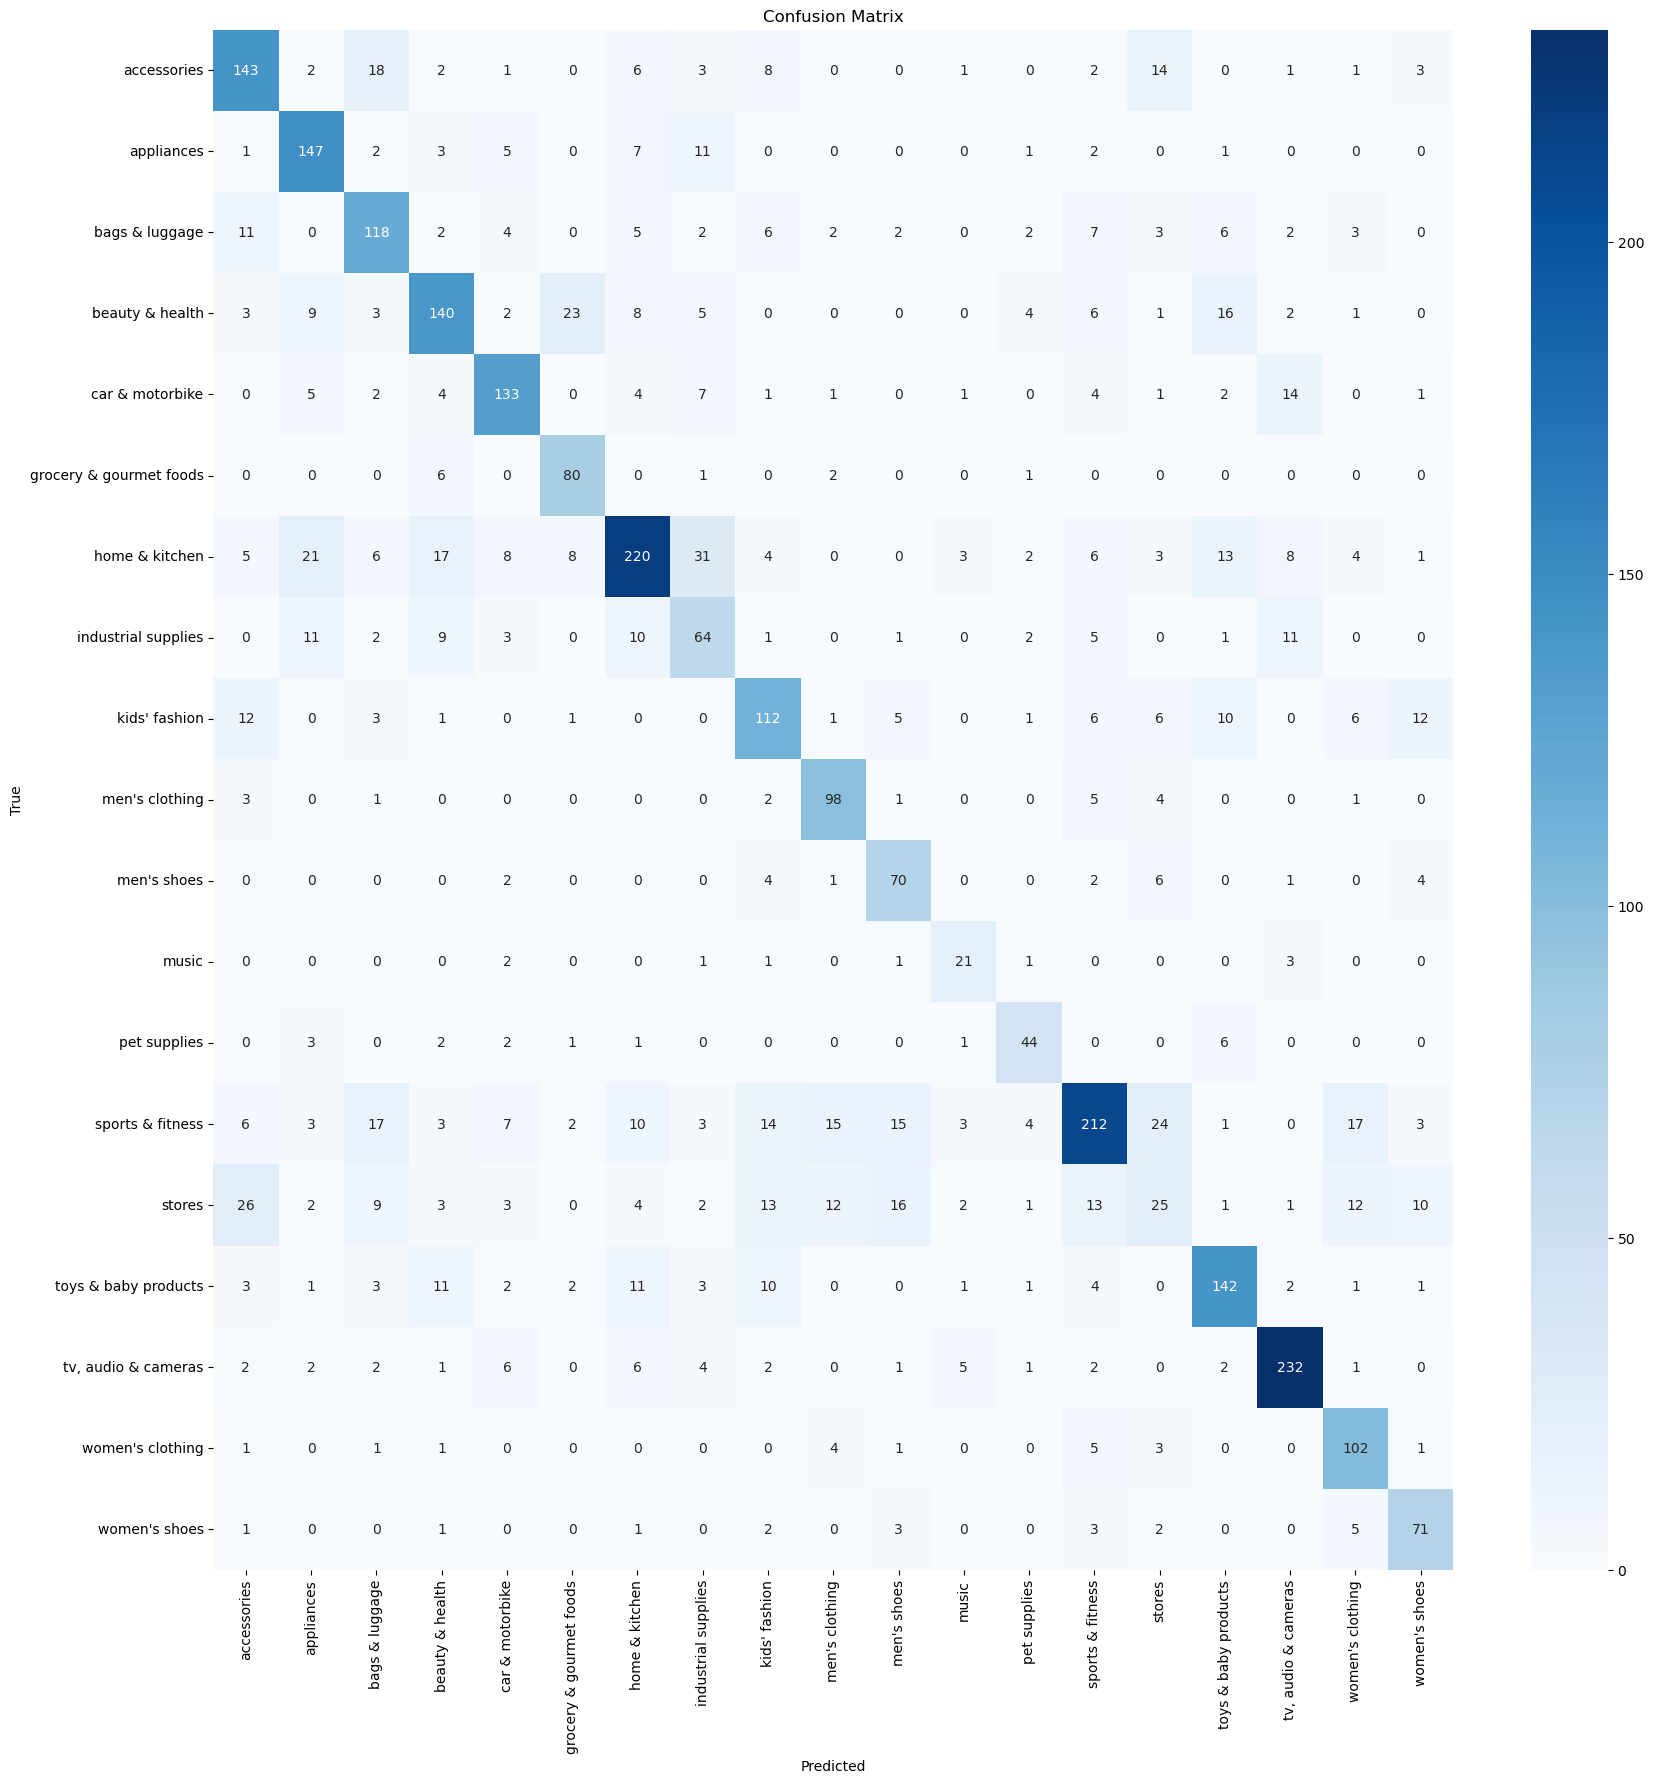

In [57]:
cm = confusion_matrix(y_test_main, y_pred_test_main)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Обучение с использованием изображений

In [37]:
vectorizer = ImageVectorizer(image_path=image_path)

X_train_img = vectorizer.fit_transform(train['image_name'])
X_test_img = vectorizer.transform(test['image_name'])

X_train_cv = np.concatenate([X_train_text, X_train_img], axis=1)
X_test_cv = np.concatenate([X_test_text, X_test_img], axis=1)

Found 12768 validated image filenames.


C:\Users\Diadaro\anaconda3\envs\dissert\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 3193 validated image filenames.


Кодирование подкатегорий, добавление предсказанных категорий в признаковую выборку:

In [38]:
encoder_sub = LabelEncoder()
y_train_sub = encoder_sub.fit_transform(train['sub_category'])
y_test_sub = encoder_sub.transform(test['sub_category'])

ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

cat_train_main = ohe.fit_transform(y_pred_train_main.reshape(-1, 1))
cat_test_main = ohe.transform(y_pred_test_main.reshape(-1, 1))

X_train_final = np.concatenate([X_train_cv, cat_train_main], axis=1)
X_test_final = np.concatenate([X_test_cv, cat_test_main], axis=1)

In [43]:
param_grid_2 = [
    {
        'clf': [LGBMClassifier(random_state=RANDOM)],
        'clf__n_estimators': [200, 500],
        'clf__learning_rate': [0.05, 0.1],
        'clf__max_depth': [-1],
        'clf__num_leaves': [31, 63],
        'clf__min_child_samples': [20, 50],
        'clf__subsample': [0.8],
        'clf__colsample_bytree': [0.8],
         'thread_count': [1]
    },
    {
        'clf': [CatBoostClassifier(random_state=RANDOM, verbose=0)],
        'clf__iterations': [300, 500],           
        'clf__learning_rate': [0.05, 0.1],
        'clf__depth': [6],
        'clf__l2_leaf_reg': [3, 5],
        'clf__n_jobs': [1]
    },
    {
        'clf': [XGBClassifier(random_state=RANDOM, use_label_encoder=False, eval_metric='mlogloss', num_class=len(np.unique(y_train_sub)))],
        'clf__n_estimators': [200, 500],
        'clf__learning_rate': [0.05, 0.1],
        'clf__max_depth': [-1],
        'clf__subsample': [0.8],
        'clf__colsample_bytree': [0.8],
        'clf__reg_alpha': [0, 1],
        'clf__reg_lambda': [1, 3],
        'clf__n_jobs': [1]
    }
]

In [44]:
halving_cv = HalvingGridSearchCV(
    estimator=pipe,
    param_grid=param_grid_2,
    scoring="f1_macro",
    cv=cv,
    factor=3,
    n_jobs=-1
)


sample_weights_cv = compute_sample_weight(class_weight="balanced", y=y_train_sub)

halving_cv.fit(X_train_final, y_train_sub, clf__sample_weight=sample_weights_cv)

print("Лучшие параметры:", halving_cv.best_params_)
print("Лучший f1_macro на кросс-валидации:", halving_cv.best_score_)

best_model_cv = halving_cv.best_estimator_

C:\Users\Diadaro\anaconda3\envs\dissert\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
72 fits failed out of a total of 120.
Лучшие параметры: {'clf': LGBMClassifier(random_state=42), 'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 6, 'clf__min_child_samples': 50, 'clf__n_estimators': 500, 'clf__n_jobs': 1, 'clf__num_leaves': 63, 'clf__subsample': 0.8}
Лучший f1_macro на кросс-валидации: 0.4274792444992575


In [48]:
y_pred = best_model_cv.predict(X_test_final)

print('Метрика f1-macro на тесте:', f1_score(y_test_sub, y_pred, average='macro'))

C:\Users\Diadaro\anaconda3\envs\dissert\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Метрика f1-macro на тесте: 0.43175919683086755


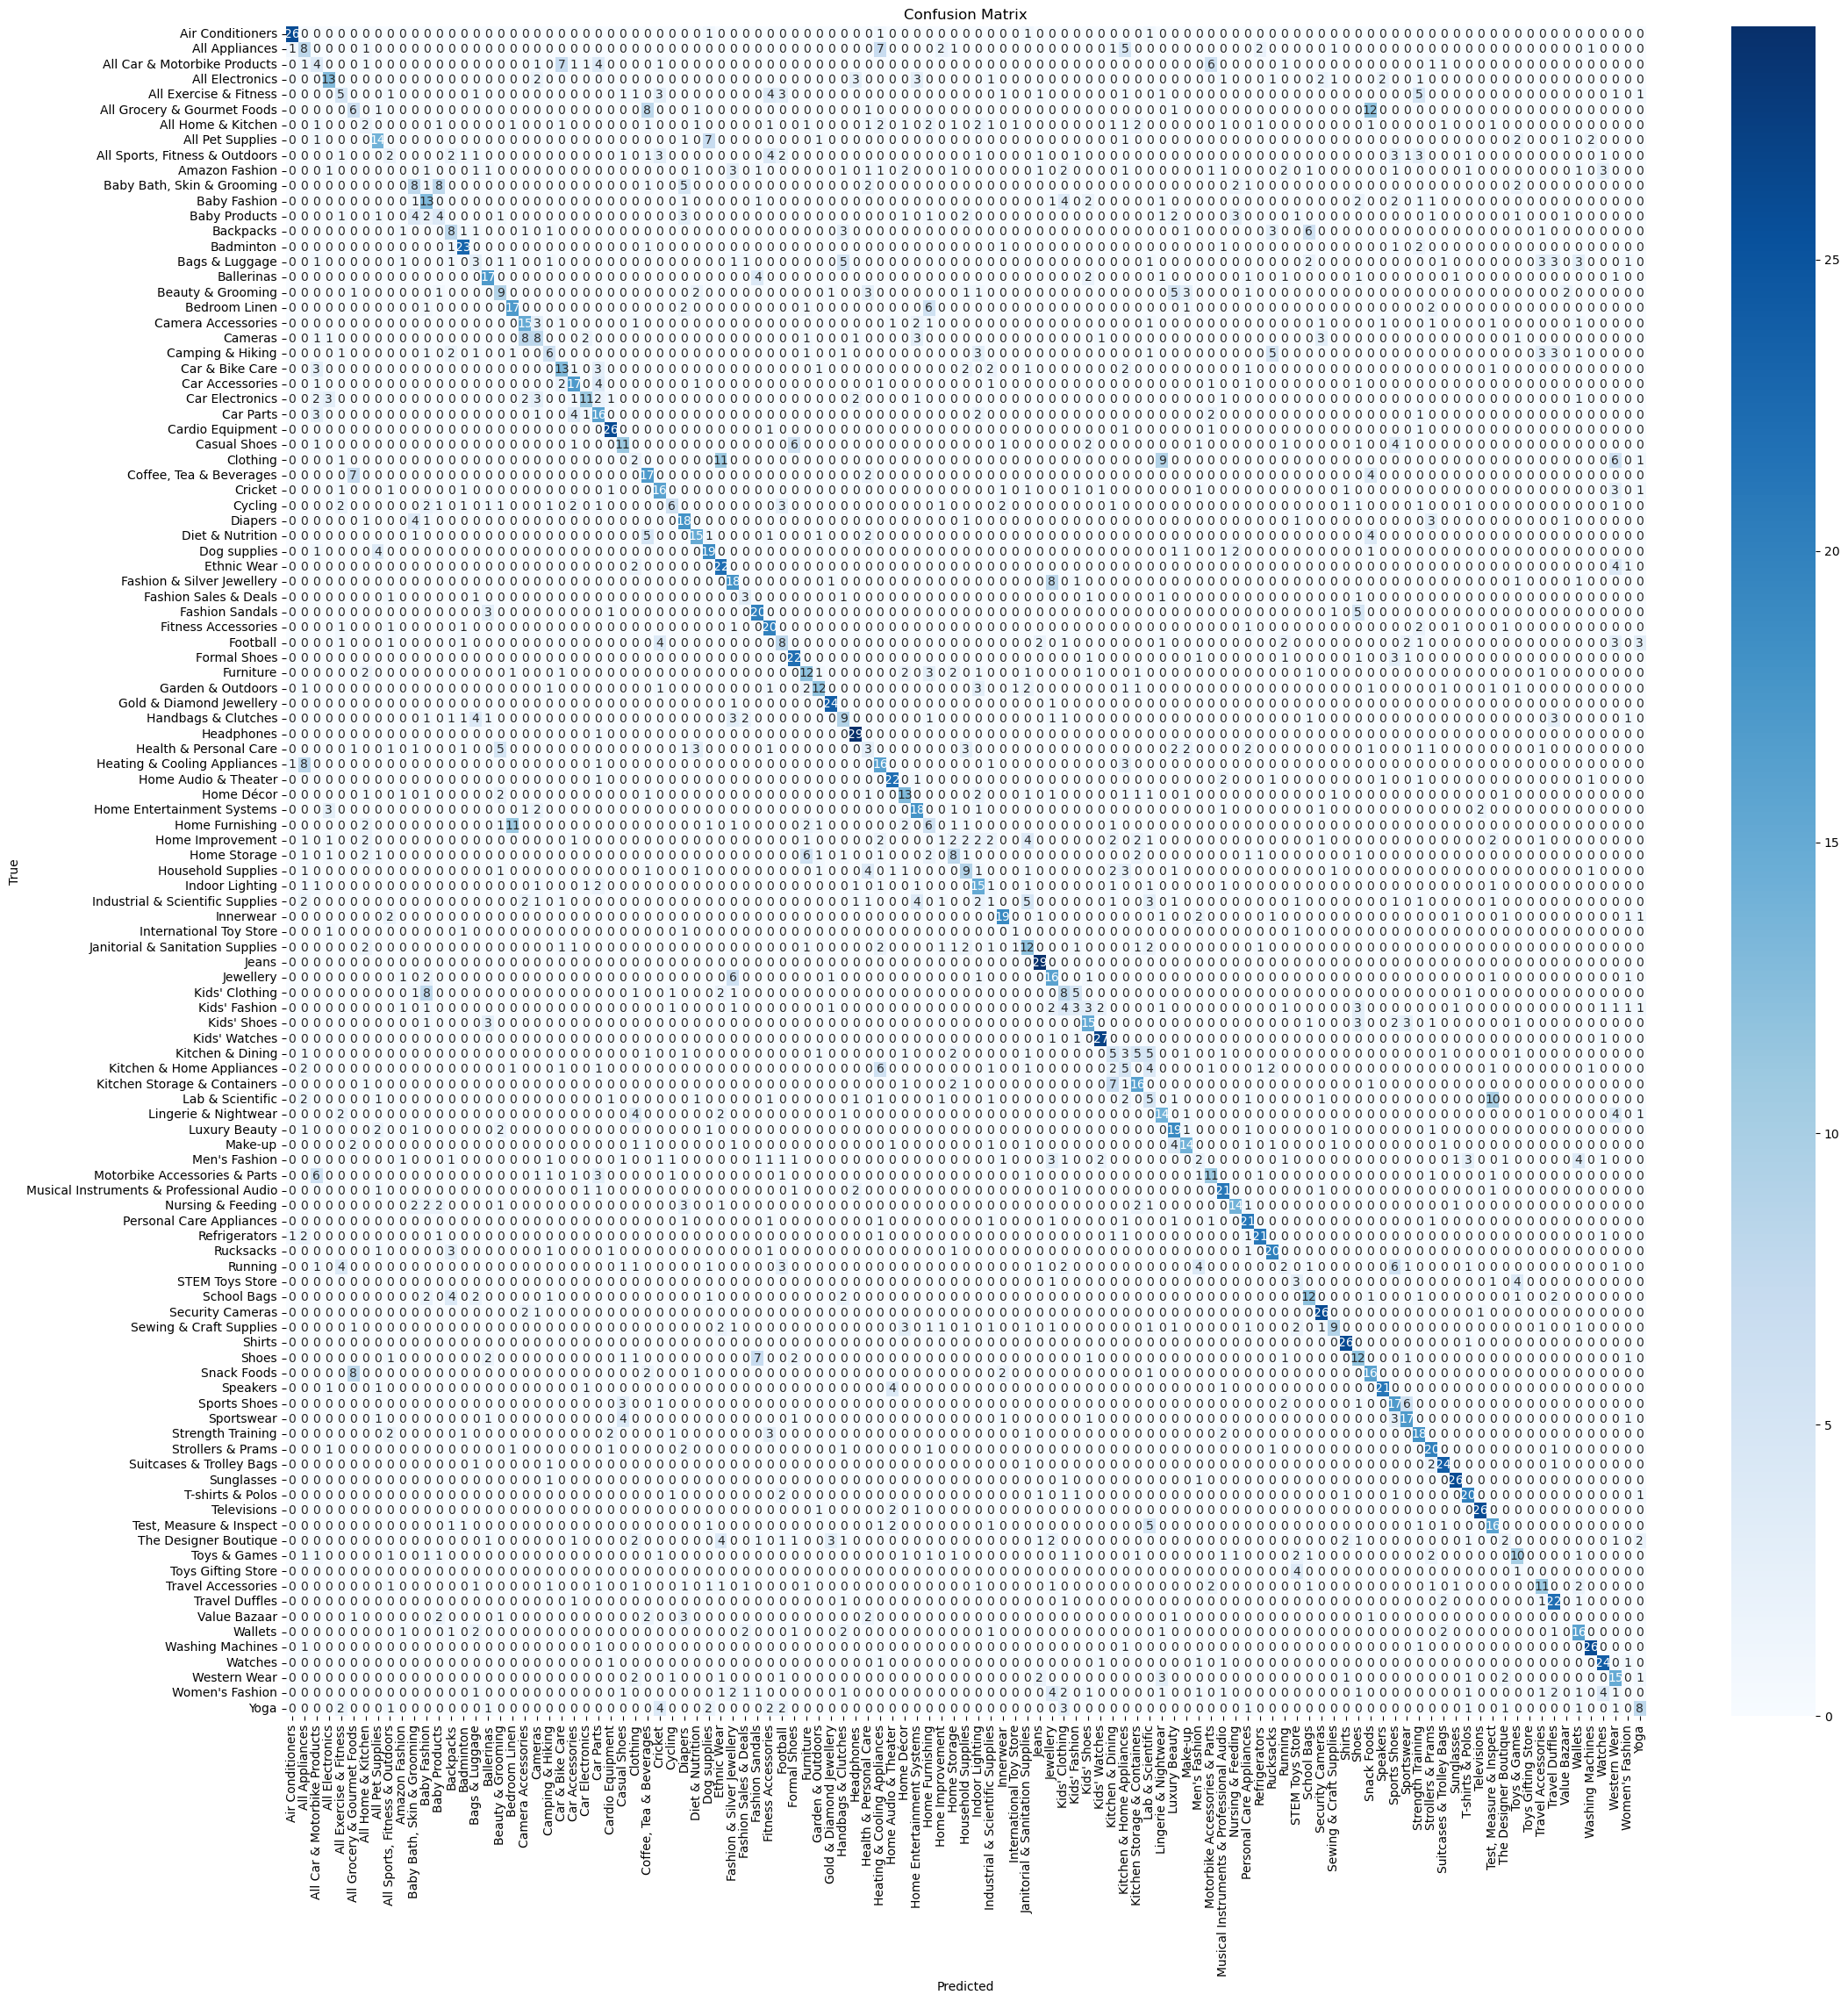

In [58]:
cm = confusion_matrix(y_test_sub, y_pred)

plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=encoder_sub.classes_, 
            yticklabels=encoder_sub.classes_)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Вывод

Целью работы была разработка подхода к автоматической классификации объявлений или товаров по категориям, чтобы улучшить процесс модерации и поиска.

В процессе подготовлен датасет, включающий текстовые описания и изображения товаров. Всего 15961 товар, 3 000 описаний, 15961 изображение.
Каталог разбит на два уровня: основная категория, подкатегория. Подкатегории являются уникальными и входят только в одну категорию.

До обучения тексты и изображения подверглись векторизации (для текстов использована модель BERT, для изображений - свертачная нейронная сеть ResNet50).

Обучение моделей разбито на две части:
- Обучение предсказания категорий на основе текста описания товара. В переборе параметров участвовали три линейные модели LogisticRegression, LinearSVC, RidgeClassifier, т.к. линейные модели эффективнее работают с текстами в векторном представлении.
- Обучение предсказания подкатегорий на основе текста описания, изображения и предсказанной категории товара на первом этапе. Для обучения отобраны бустинговые модели LGBMClassifier, CatBoostClassifier и XGBClassifier, благодаря большей эффективности при работе с данными, включающими изображения.

Качество предсказаний оценивалось метрикой f1 macro. Она усредняет метрику f1 по каждому из классов, не позволяя завысить значение. Так получится более реальная картина предсказаний.

В первой части лучшее значение метрики показано на модели LogisticRegression, лучший f1_macro на тесте: 0.670. Показатель далеко не отличный, на низкое качество влияет:
- несбалалансированность товаров по категориям в датасете;
- малое количество примеров некоторых категорий;
- близость категорий по своему значению (перекрытие).
На матрице корреляции можно заметить множество примеров неверно предсказаной категории stores, таких категорий стоит избегать при создании каталогов. также имеется категория sports&fitness, модель распределяет товары данной категории по остальным, имеющим отношение к одежде (kid's fashion, man's clothing, man's shoes, women's shoes, woman's clothing и так далее).

Вторая часть обучения включает в себя комбинацию реальных подкатегорий товара и предсказанных категорий из первой части.
Модель должна ориентироваться и на категорию товара, т.к. подкатегории уникальны, даже если категория предсказана неверно. Таким образом, качество предсказания подкатегорий зависит от точности предсказания категорий, в этом и заключается сложность классификации многоуровневых каталогов. Лучшая из бустинговых моделей LGBMClassifier с метрикой f1-macro на тесте: 0.432. Точность еще ниже относительно предсказанных категорий, что объясняется зависимостью от эффективности предсказания категорий. На матрице корреляций видно много неверно предсказанных единичных примеров, также встречаются и примеры, отнесенные к другому классу из-за перекрытия подкатегорий, например 8 товаров snack foods ошибочно отнесены к подкатегории all grocery & foods.

Разработанный подход не лишен своих недостатков и нуждается в доработке. Необходимо повышать эффективность предсказания категорий товаров за счет наполнения датасета мало представленными товарными категориями, отбором товаров с наличием текста описания. Лишь повысив ээфективность в предсказании категорий, точность определения подкатегории сама по себе возрастет, однако, для достижения наилучшего качества стоит поработать с обучением на нейросетях.